In [48]:
import sys
sys.path.append('../')
from utilities.data_manager import ExchangeDataManager, volume_based_resampling
import pandas as pd
from lightweight_charts import Chart
from lightweight_charts import JupyterChart
import ta
import numpy as np
from utilities.bt_analysis import get_metrics, backtest_analysis
from utilities.plot_analysis import plot_equity_vs_asset, plot_futur_simulations, plot_bar_by_month

In [49]:
exchange_name = "binance"
pair = "BTC/USDT"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df1m = exchange.load_data(pair, "1m")
df1m

,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2024-05-21 16:56:00,69825.71,69825.72,69786.00,69786.00,20.017320
2024-05-21 16:57:00,69786.00,69798.72,69738.86,69743.59,24.603310
2024-05-21 16:58:00,69743.58,69764.50,69730.83,69742.73,37.527200


In [50]:
df1h = exchange.load_data(pair, "1h")
dt = df1h.copy().loc["2024-05"]
dt["time"] = dt.index
chart = JupyterChart(width=900, height=400)
chart.set(dt)
chart.load()

In [51]:
dfr = volume_based_resampling(df1m, (df1m.index[-1] - df1m.index[0]).days * 24)
dtr = dfr.copy().loc["2024-05"]
dtr["time"] = dtr.index
chart = JupyterChart(width=900, height=400)
chart.set(dtr)
chart.load()
# dfr

In [52]:
class TrendStrategy():
    def __init__(
        self,
        pair,
        df,
        type=["long"],
        params={},
    ):
        self.pair = pair
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

        
    def populate_indicators(self):
        params = self.params
        df = self.df
        df.drop(
            columns=df.columns.difference(['open','high','low','close','volume']), 
            inplace=True
        )
        
        # -- Populate indicators --
        bol_band = ta.volatility.BollingerBands(close=df["close"], window=params["bol_window"], window_dev=params["bol_std"])
        df["lower_band"] = bol_band.bollinger_lband()
        df["higher_band"] = bol_band.bollinger_hband()
        df["ma_band"] = bol_band.bollinger_mavg()
    
        self.df = df

        return self.df
    
    def populate_buy_sell(self): 
        params = self.params
        df = self.df

        df["open_long"] = np.where((df['close'] >= df['higher_band']), True, False) if self.use_long else False
        df["close_long"] = np.where((df['close'] < df['ma_band']), True, False)
        self.df = df
        
        return self.df
        
    def run_backtest(self, initial_wallet=1000, leverage=1):
        params = self.params
        df_ini = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0006
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None
        
        for index, row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['open']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        close_size = current_position['size'] + current_position['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - current_position['size'] - fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['open'],
                    "long_exposition":0,
                    "short_exposition":0,
                    "risk":0,
                })
            previous_day = current_day 
            
            # -- Close LONG --
            # Close Market    
            if current_position and current_position['side'] == "LONG" and row['close_long']:
                close_price = row['close']
                trade_result = (close_price - current_position['price']) / current_position['price']
                close_size = current_position['size'] + current_position['size'] * trade_result
                fee = close_size * taker_fee
                wallet += close_size - current_position['size'] - fee
                trades.append({
                    "pair": self.pair,
                    "open_date": current_position['date'],
                    "close_date": index,
                    "position": current_position['side'],
                    "open_reason": current_position['reason'],
                    "close_reason": "Market",
                    "open_price": current_position['price'],
                    "close_price": close_price,
                    "open_fee": current_position['fee'],
                    "close_fee": fee,
                    "open_trade_size":current_position['size'],
                    "close_trade_size":close_size,
                    "wallet": wallet,
                })
                current_position = None
                    
            # -- Check for opening position --
            # -- Open LONG --
            if current_position is None and row['open_long']:
                open_price = row["close"]
                pos_size = wallet * leverage
                fee = pos_size * taker_fee
                pos_size -= fee
                wallet -= fee
                current_position = {
                    "size": pos_size,
                    "date": index,
                    "price": open_price,
                    "fee":fee,
                    "reason": "Market",
                    "side": "LONG",
                }         
                        
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }
    

class MeanReversionStrategy():
    def __init__(
        self,
        pair,
        df,
        type=["long"],
        params={},
    ):
        self.pair = pair
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

        
    def populate_indicators(self):
        params = self.params
        df = self.df
        df.drop(
            columns=df.columns.difference(['open','high','low','close','volume']), 
            inplace=True
        )
        
        # -- Populate indicators --
        bol_band = ta.volatility.BollingerBands(close=df["close"], window=params["bol_window"], window_dev=params["bol_std"])
        df["lower_band"] = bol_band.bollinger_lband()
        df["higher_band"] = bol_band.bollinger_hband()
        df["ma_band"] = bol_band.bollinger_mavg()
    
        self.df = df

        return self.df
    
    def populate_buy_sell(self): 
        params = self.params
        df = self.df

        df["open_long"] = np.where((df['close'] <= df['lower_band']), True, False) if self.use_long else False
        # df["close_long"] = np.where((df['close'] > df['ma_band']), True, False)
        df["close_long"] = False
        self.df = df
        
        return self.df
        
    def run_backtest(self, initial_wallet=1000, leverage=1):
        params = self.params
        df_ini = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0006
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None
        
        for index, row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['open']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        close_size = current_position['size'] + current_position['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - current_position['size'] - fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['open'],
                    "long_exposition":0,
                    "short_exposition":0,
                    "risk":0,
                })
            previous_day = current_day 
            
            # -- Close LONG --

            # Close SL    
            if current_position and current_position['side'] == "LONG" and row['low'] <= current_position['sl']:
                close_price = current_position['sl']
                trade_result = (close_price - current_position['price']) / current_position['price']
                close_size = current_position['size'] + current_position['size'] * trade_result
                fee = close_size * taker_fee
                wallet += close_size - current_position['size'] - fee
                trades.append({
                    "pair": self.pair,
                    "open_date": current_position['date'],
                    "close_date": index,
                    "position": current_position['side'],
                    "open_reason": current_position['reason'],
                    "close_reason": "SL",
                    "open_price": current_position['price'],
                    "close_price": close_price,
                    "open_fee": current_position['fee'],
                    "close_fee": fee,
                    "open_trade_size":current_position['size'],
                    "close_trade_size":close_size,
                    "wallet": wallet,
                })
                current_position = None
            # Close TP    
            if current_position and current_position['side'] == "LONG" and row['high'] >= current_position['tp']:
                close_price = current_position['tp']
                trade_result = (close_price - current_position['price']) / current_position['price']
                close_size = current_position['size'] + current_position['size'] * trade_result
                fee = close_size * taker_fee
                wallet += close_size - current_position['size'] - fee
                trades.append({
                    "pair": self.pair,
                    "open_date": current_position['date'],
                    "close_date": index,
                    "position": current_position['side'],
                    "open_reason": current_position['reason'],
                    "close_reason": "TP",
                    "open_price": current_position['price'],
                    "close_price": close_price,
                    "open_fee": current_position['fee'],
                    "close_fee": fee,
                    "open_trade_size":current_position['size'],
                    "close_trade_size":close_size,
                    "wallet": wallet,
                })
                current_position = None
            # Close Market    
            if current_position and current_position['side'] == "LONG" and row['close_long']:
                close_price = row['close']
                trade_result = (close_price - current_position['price']) / current_position['price']
                close_size = current_position['size'] + current_position['size'] * trade_result
                fee = close_size * taker_fee
                wallet += close_size - current_position['size'] - fee
                trades.append({
                    "pair": self.pair,
                    "open_date": current_position['date'],
                    "close_date": index,
                    "position": current_position['side'],
                    "open_reason": current_position['reason'],
                    "close_reason": "Market",
                    "open_price": current_position['price'],
                    "close_price": close_price,
                    "open_fee": current_position['fee'],
                    "close_fee": fee,
                    "open_trade_size":current_position['size'],
                    "close_trade_size":close_size,
                    "wallet": wallet,
                })
                current_position = None
                    
            # -- Check for opening position --
            # -- Open LONG --
            if current_position is None and row['open_long']:
                open_price = row["close"]
                pos_size = wallet * leverage
                fee = pos_size * taker_fee
                pos_size -= fee
                wallet -= fee
                # sl_price = row["close"] - (row["ma_band"] - row["close"])
                # tp_price = row["ma_band"]
                sl_price = row["close"] * 0.96
                tp_price = row["close"] * 1.07
                current_position = {
                    "size": pos_size,
                    "date": index,
                    "price": open_price,
                    "fee":fee,
                    "reason": "Market",
                    "side": "LONG",
                    "sl": sl_price,
                    "tp": tp_price,
                }         
                        
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }  

Period: [2017-10-19 00:00:00] -> [2024-05-21 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 5425.87 $
Performance: 442.59 %
Sharpe Ratio: 0.78 | Sortino Ratio: 1.37 | Calmar Ratio: 0.54
Worst Drawdown T|D: -67.74% | -67.43%
Buy and hold performance: 1186.67 %
Performance vs buy and hold: -57.83 %
Total trades on the period: 1902
Average Profit: 0.19 %
Global Win rate: 31.07 %

--- Trades Information ---
Mean Trades per day: 0.79
Mean Trades Duration: 0 days 12:27:14.984227129
Best trades: +83.1 % the 2017-11-14 13:04:00 -> 2017-12-09 12:56:00 (BTC/USDT)
Worst trades: -6.83 % the 2018-01-23 16:21:00 -> 2018-01-23 23:45:00 (BTC/USDT)
Total Good trades on the period: 591
Total Bad trades on the period: 1311
Average Good Trades result: 2.82 %
Average Bad Trades result: -0.99 %
Mean Good Trades Duration: 1 days 00:14:41.116751269
Mean Bad Trades Duration: 0 days 07:08:20.228832951

--- Days Informations ---
Total: 2397 days recorded
Winning days: 747 days (31.

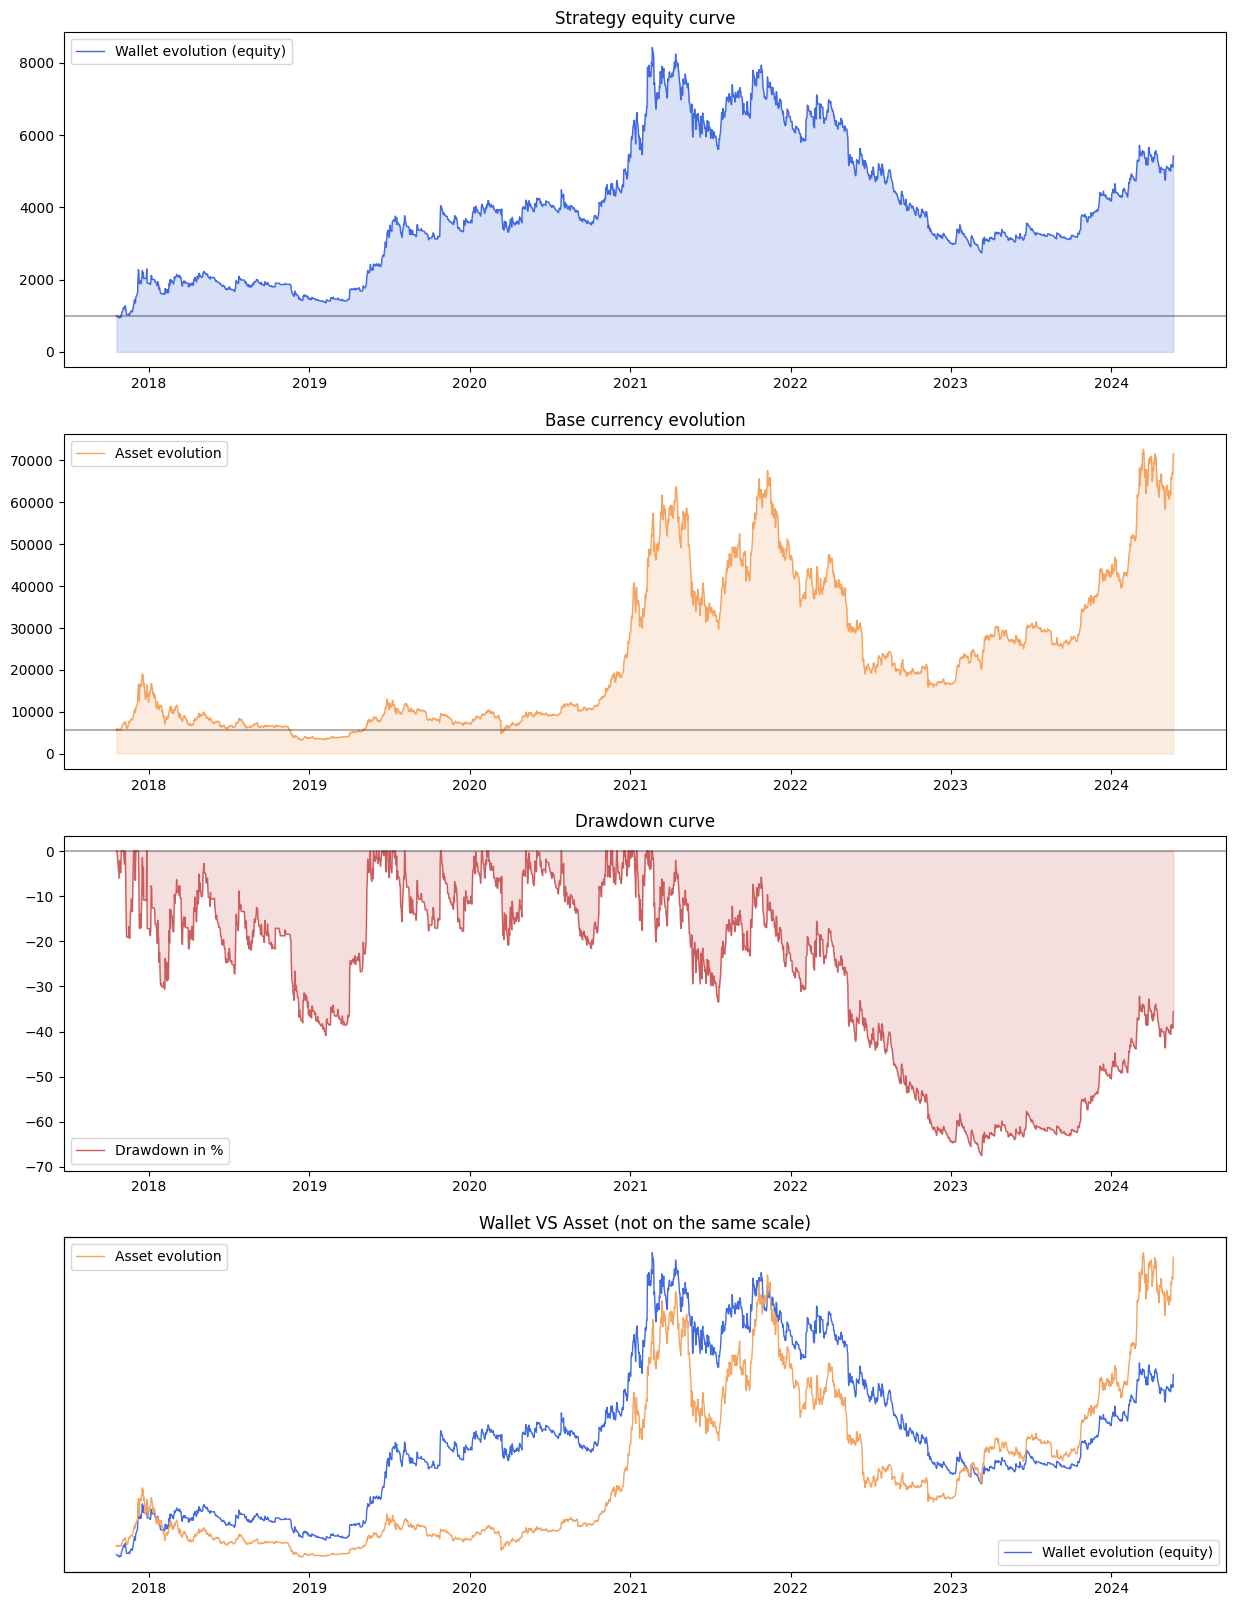

In [58]:
params = {
    "bol_window": 20,
    "bol_std": 1,
}

strat = TrendStrategy(
    pair=pair,
    df=dfr,
    type=["long"],
    params=params,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)

df_trades, df_days = backtest_analysis(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=True,
    pair_info=True,
    indepedant_trade=True
)
plot_equity_vs_asset(df_days=df_days.loc[:])

Period: [2018-06-10 00:00:00] -> [2024-05-21 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 1957.4 $
Performance: 95.74 %
Sharpe Ratio: 0.59 | Sortino Ratio: 0.46 | Calmar Ratio: 0.37
Worst Drawdown T|D: -38.77% | -38.77%
Buy and hold performance: 859.14 %
Performance vs buy and hold: -79.59 %
Total trades on the period: 126
Average Profit: 0.74 %
Global Win rate: 43.65 %

--- Trades Information ---
Mean Trades per day: 0.06
Mean Trades Duration: 4 days 01:04:39.047619047
Best trades: +6.94 % the 2022-10-20 00:48:00 -> 2022-10-25 18:27:00 (BTC/USDT)
Worst trades: -4.06 % the 2020-06-24 07:37:00 -> 2020-06-25 03:03:00 (BTC/USDT)
Total Good trades on the period: 55
Total Bad trades on the period: 71
Average Good Trades result: 6.94 %
Average Bad Trades result: -4.06 %
Mean Good Trades Duration: 5 days 22:42:15.272727272
Mean Bad Trades Duration: 2 days 13:43:58.309859154

--- Days Informations ---
Total: 2173 days recorded
Winning days: 307 days (14.13%)
Ne

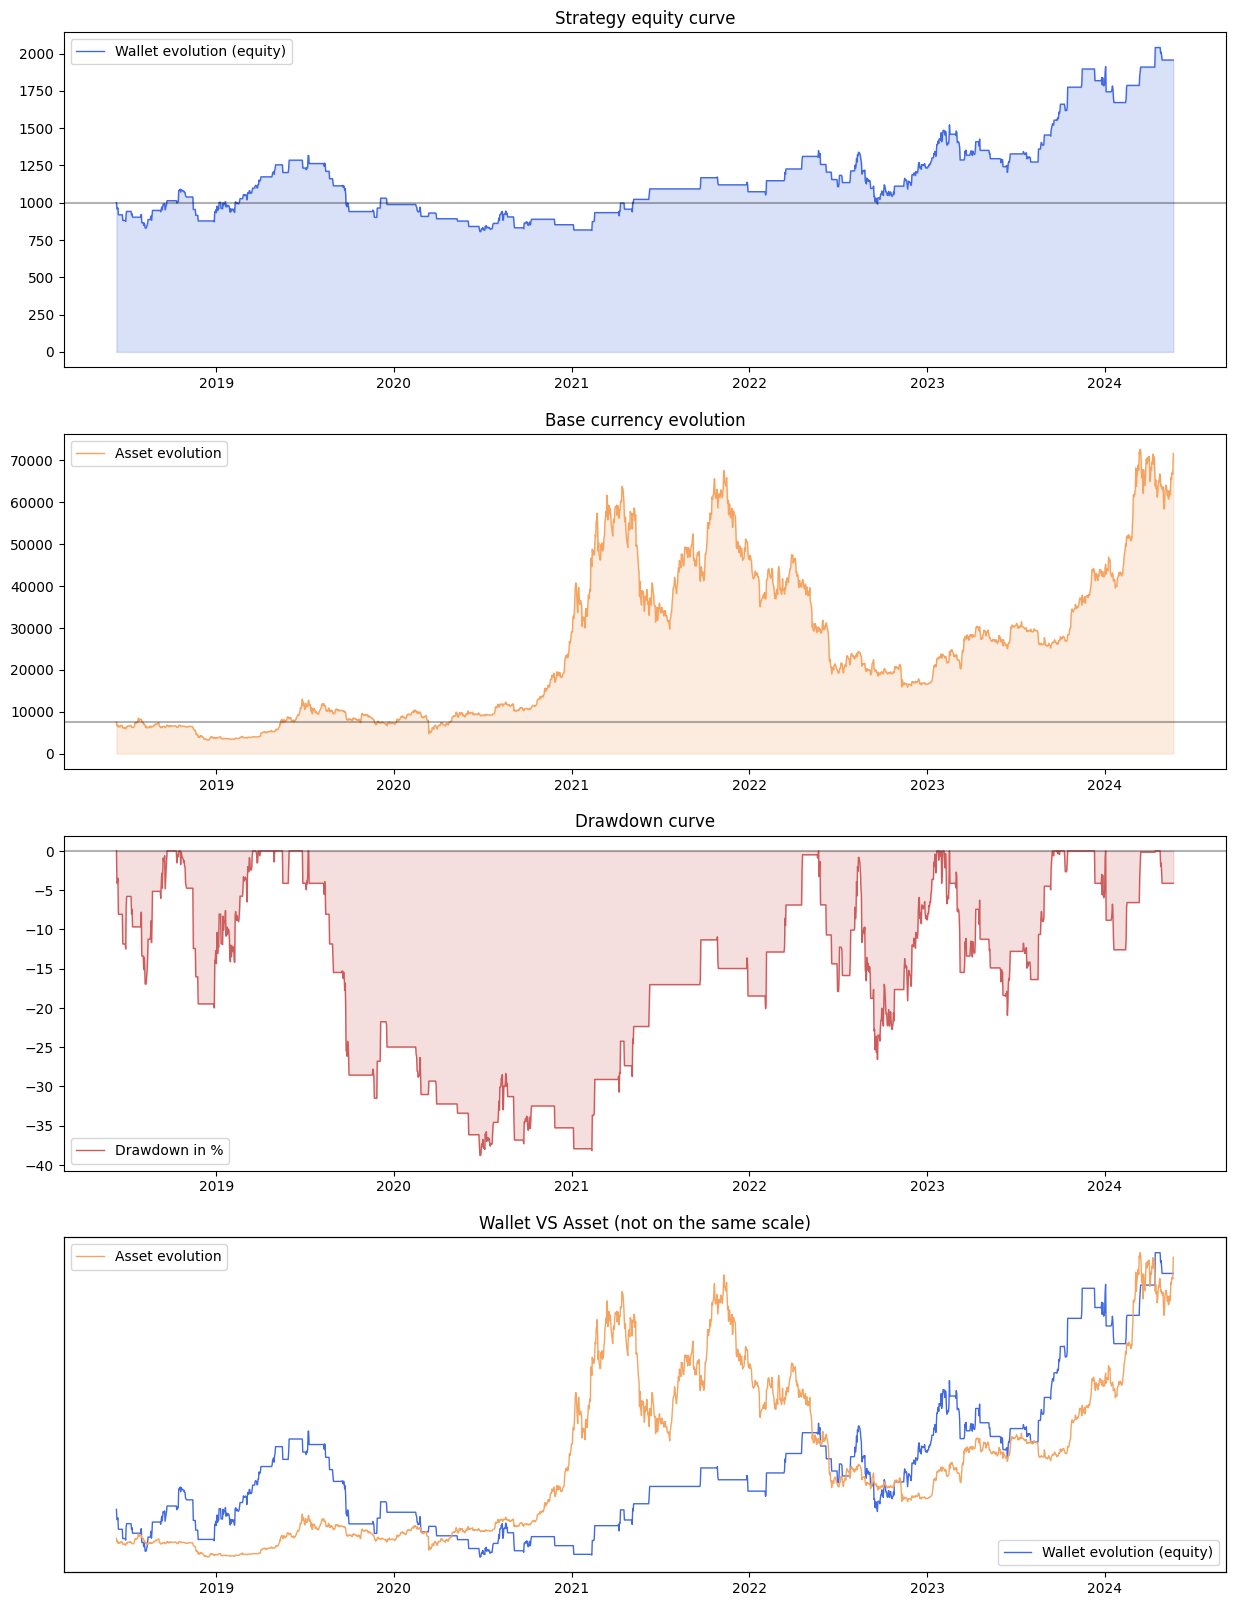

In [63]:
params = {
    "bol_window": 20,
    "bol_std": 3,
}

strat = MeanReversionStrategy(
    pair=pair,
    df=dfr,
    type=["long"],
    params=params,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)

df_trades, df_days = backtest_analysis(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=True,
    pair_info=True,
    indepedant_trade=True
)
plot_equity_vs_asset(df_days=df_days.loc[:])

In [55]:
df_trades["close_reason"].value_counts()
# df_trades

close_reason
SL    71
TP    55
Name: count, dtype: int64